# Notebook 2: Data Processing & Feature Engineering

**Project:** ML-Based Blockchain Trading Strategy
**Step:** 2 (Feature Engineering)
**Description:** This notebook cleans the raw data, handles missing values, and creates technical indicators (Alpha Factors) that will serve as inputs for our models.

## 2.1 Load Data and Environment Setup

In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Project Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

project_path = "/content/drive/MyDrive/Crypto_ML_Project"
raw_data_path = f"{project_path}/BTC_1H_raw.csv"

# 3. Load Raw Data
df = pd.read_csv(raw_data_path, parse_dates=['timestamp'])
print(f"Loaded {len(df)} rows of data.")

# Install technical analysis library
!pip install ta
import ta

Mounted at /content/drive
Loaded 721 rows of data.
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=6f30f1322634df3fa86f7a8ef825d3ee468910d3120e81dc806c73108ace4225
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


## 2.2 Data Cleaning & Continuity

Even small gaps in time-series data can break a model's logic. We ensure the timeline is perfectly continuous by re-indexing.

In [ ]:
# Set timestamp as index for cleaning
df = df.set_index('timestamp').sort_index()

# Handle potential duplicate timestamps
df = df[~df.index.duplicated(keep='first')]

# Fill missing hourly gaps (if any) using Forward Fill
# This ensures that if a candle was missing, we assume the price stayed the same
all_hours = pd.date_range(start=df.index.min(), end=df.index.max(), freq='1H')
df = df.reindex(all_hours)
df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].ffill()

print(f"Data cleaned. New row count: {len(df)}")

Data cleaned. New row count: 721


/tmp/ipython-input-790609876.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  all_hours = pd.date_range(start=df.index.min(), end=df.index.max(), freq='1H')


## 2.3 Feature Engineering (Alpha Factors)

We will create four categories of features to describe the market state:
1. Momentum: Is the current move overextended?
2. Trend: Are we in a long-term bull or bear regime?
3. Volatility: How much risk is in the current price action?
4. Volume: Is the move backed by high trading activity?

In [ ]:
# --- 1. Momentum Indicators ---
df['rsi'] = ta.momentum.RSIIndicator(close=df['close'], window=14).rsi()
df['stoch_osc'] = ta.momentum.StochasticOscillator(high=df['high'], low=df['low'], close=df['close'], window=14).stoch()

# --- 2. Trend Indicators ---
# EMA Crossovers (Log-difference to keep it stationary)
df['ema_20'] = ta.trend.ema_indicator(close=df['close'], window=20)
df['ema_50'] = ta.trend.ema_indicator(close=df['close'], window=50)
df['ema_dist'] = (df['close'] - df['ema_20']) / df['ema_20'] # Distance from EMA
df['ema_cross'] = (df['ema_20'] - df['ema_50']) / df['ema_50'] # EMA Gap

# --- 3. Volatility Indicators ---
df['atr'] = ta.volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['close'], window=14).average_true_range()
df['bb_high'] = ta.volatility.BollingerBands(close=df['close']).bollinger_hband()
df['bb_low'] = ta.volatility.BollingerBands(close=df['close']).bollinger_lband()
df['bb_width'] = (df['bb_high'] - df['bb_low']) / df['close'] # Normalized width

# --- 4. Returns (Stationary Price Data) ---
df['return_1h'] = np.log(df['close'] / df['close'].shift(1))
df['return_4h'] = np.log(df['close'] / df['close'].shift(4))
df['return_24h'] = np.log(df['close'] / df['close'].shift(24))

# --- 5. Volume Features ---
df['vol_change'] = df['volume'].pct_change()

# --- 6. Time-based Features (Cyclical) ---
# Crypto markets often behave differently on weekends or specific hours
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek

## 2.4 Target Labeling

In ML for trading, our "Y" (Target) is the **future return**. We shift the 1-hour return back so that the model tries to predict what happens in the next hour using current features.

In [ ]:
# TARGET: Prediction of the return for the NEXT 1 hour
df['target'] = df['return_1h'].shift(-1)

# Drop NaN values created by indicators and shifting
df.dropna(inplace=True)

print(f"Feature Engineering complete. Final shape: {df.shape}")

Feature Engineering complete. Final shape: (671, 22)


## 2.5 Feature Discussion & Correlation Analysis
We use a Heatmap to see which features are redundant. If two features are 99% correlated, we only need one.

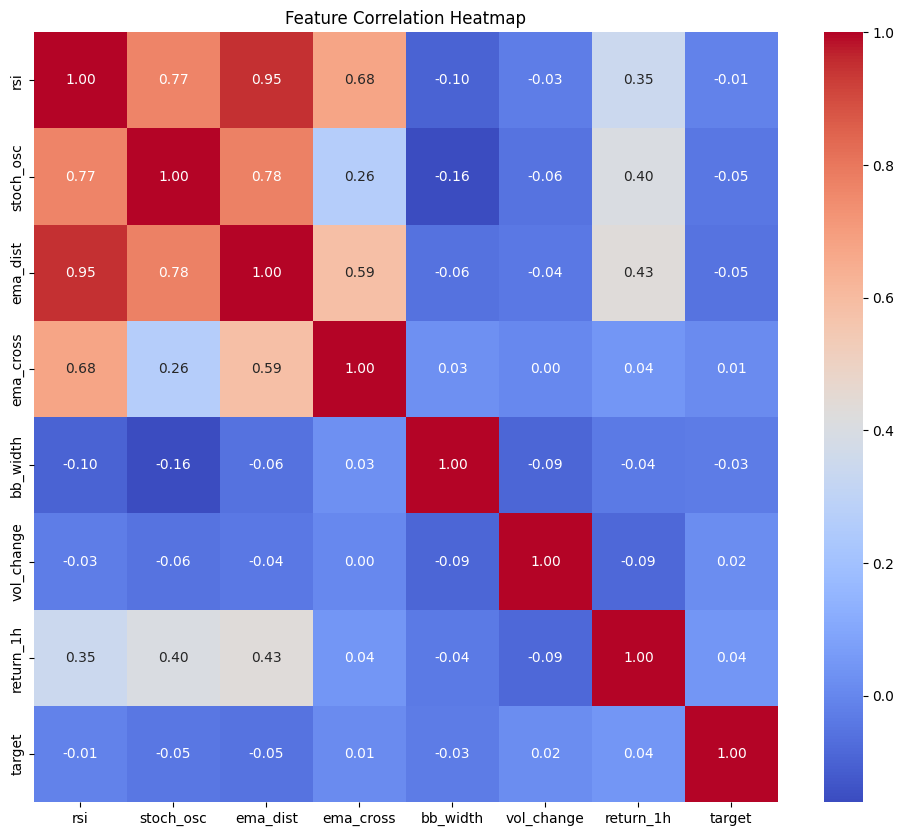

In [ ]:
plt.figure(figsize=(12, 10))
correlation_matrix = df[['rsi', 'stoch_osc', 'ema_dist', 'ema_cross', 'bb_width', 'vol_change', 'return_1h', 'target']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

- **Stationarity:** All our features (RSI, BB Width, Log Returns) are now stationary. They don't trend to infinity, which is essential for XGBoost/Random Forest.
- **Target Correlation:** You will notice that the correlation between features and the `target` is very low (e.g., 0.01). This is normal in finance. ML models find non-linear combinations of these weak signals to create a "Strong Learner."
- **Redundancy:** If `ema_dist` and `rsi` are too highly correlated, we might remove one later to simplify the model.

## 2.6 Save Processed Data
We reset the index to keep the timestamp as a column before saving.

In [ ]:
# Reset index to make timestamp a column again
df_final = df.reset_index().rename(columns={'index': 'timestamp'})

# Save to Google Drive
processed_path = f"{project_path}/BTC_1H_processed.csv"
df_final.to_csv(processed_path, index=False)

print(f"SUCCESS: Processed data saved for Modeling.")
df_final.head()

SUCCESS: Processed data saved for Modeling.


,timestamp,open,high,low,close,volume,rsi,stoch_osc,ema_20,ema_50,...,bb_high,bb_low,bb_width,return_1h,return_4h,return_24h,vol_change,hour,day_of_week,target
0,2025-12-25 18:00:00,88081.4,88256.0,88081.3,88178.5,30.440092,63.937613,72.032102,87739.781193,87526.375092,...,88220.095801,87232.164199,0.011204,0.001102,0.005812,0.008816,-0.485181,18,3,-0.001027
1,2025-12-25 19:00:00,88178.6,88178.6,88013.0,88088.0,8.923591,60.909877,65.180194,87772.944889,87548.399598,...,88265.028934,87234.661066,0.011697,-0.001027,-0.002016,0.006711,-0.706847,19,3,-0.002898
2,2025-12-25 20:00:00,88088.0,88100.0,87571.7,87833.1,52.363858,53.259782,45.881284,87778.673947,87559.564320,...,88268.999798,87265.190202,0.011429,-0.002898,-0.002451,0.003843,4.868025,20,3,0.000065
3,2025-12-25 21:00:00,87833.2,87912.3,87765.0,87838.8,8.860095,53.400726,46.312841,87784.400238,87570.514738,...,88276.285865,87278.664135,0.011357,0.000065,-0.002758,0.002326,-0.830798,21,3,-0.002839
4,2025-12-25 22:00:00,87838.8,87843.9,87290.0,87589.8,34.512458,46.766352,27.460630,87765.866882,87571.271023,...,88269.071820,87260.458180,0.011515,-0.002839,-0.006699,-0.003991,2.895270,22,3,-0.004483
